# 08/06/2024
Fiona Zheng

In [2]:
import pandas as pd
import numpy as np
import holidays
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r'data\UNITED_eeweather_data_1422.csv')

In [4]:
df

,Unnamed: 0,Year,MONTH,DAY,TIME,Load,MW,hour_begins,temp_f
0,13097,2014,6,30,18:00:00,308789.0,308.789,2014-06-30 18:00:00-06:00,81.75164
1,13098,2014,6,30,19:00:00,303820.0,303.820,2014-06-30 19:00:00-06:00,79.88504
2,13099,2014,6,30,20:00:00,290314.0,290.314,2014-06-30 20:00:00-06:00,74.40566
3,13100,2014,6,30,21:00:00,269876.0,269.876,2014-06-30 21:00:00-06:00,69.23264
4,13101,2014,6,30,22:00:00,257788.0,257.788,2014-06-30 22:00:00-06:00,63.74084
...,...,...,...,...,...,...,...,...,...
72988,87619,2022,12,30,20:00:00,417765.0,417.765,2022-12-30 20:00:00-07:00,18.59000
72989,87620,2022,12,30,21:00:00,412312.0,412.312,2022-12-30 21:00:00-07:00,16.90394
72990,87621,2022,12,30,22:00:00,404261.0,404.261,2022-12-30 22:00:00-07:00,18.84506
72991,87622,2022,12,30,23:00:00,392621.0,392.621,2022-12-30 23:00:00-07:00,17.73950


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72993 entries, 0 to 72992
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   72993 non-null  int64  
 1   Year         72993 non-null  int64  
 2   MONTH        72993 non-null  int64  
 3   DAY          72993 non-null  int64  
 4   TIME         72993 non-null  object 
 5   Load         72993 non-null  float64
 6   MW           72993 non-null  float64
 7   hour_begins  72993 non-null  object 
 8   temp_f       72993 non-null  float64
dtypes: float64(3), int64(4), object(2)
memory usage: 5.0+ MB


In [6]:
# strip 2014-06-30 18:00:00-06:00 into 2014-06-30 18:00:00
df['hour_begins'] = df['hour_begins'].str.slice(0, 19)
df['hour_begins'] = pd.to_datetime(df['hour_begins'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72993 entries, 0 to 72992
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   72993 non-null  int64         
 1   Year         72993 non-null  int64         
 2   MONTH        72993 non-null  int64         
 3   DAY          72993 non-null  int64         
 4   TIME         72993 non-null  object        
 5   Load         72993 non-null  float64       
 6   MW           72993 non-null  float64       
 7   hour_begins  72993 non-null  datetime64[ns]
 8   temp_f       72993 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(1)
memory usage: 5.0+ MB


In [7]:
print(f'The start datetime is {df['hour_begins'].min()}')
print(f'The end datetime is {df['hour_begins'].max()}')

The start datetime is 2014-06-30 18:00:00
The end datetime is 2022-12-31 00:00:00


In [8]:
# rename 
df =df.rename(columns = {'MW':'gross_load','Year':'year', 'MONTH': 'month', 'DAY':'date'})
# from TIME 18:00:00 to get 18 only
df['hour'] = df['TIME'].str.slice(0, 2).astype(int)
df.drop(columns = ['Unnamed: 0',  'Load', 'TIME' ], inplace = True)

In [9]:
df

,year,month,date,gross_load,hour_begins,temp_f,hour
0,2014,6,30,308.789,2014-06-30 18:00:00,81.75164,18
1,2014,6,30,303.820,2014-06-30 19:00:00,79.88504,19
2,2014,6,30,290.314,2014-06-30 20:00:00,74.40566,20
3,2014,6,30,269.876,2014-06-30 21:00:00,69.23264,21
4,2014,6,30,257.788,2014-06-30 22:00:00,63.74084,22
...,...,...,...,...,...,...,...
72988,2022,12,30,417.765,2022-12-30 20:00:00,18.59000,20
72989,2022,12,30,412.312,2022-12-30 21:00:00,16.90394,21
72990,2022,12,30,404.261,2022-12-30 22:00:00,18.84506,22
72991,2022,12,30,392.621,2022-12-30 23:00:00,17.73950,23


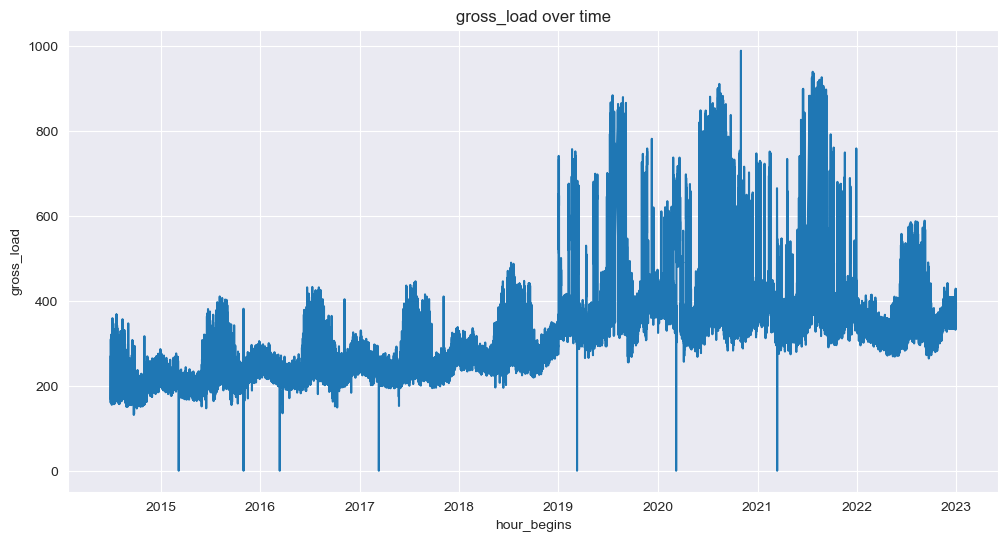

In [10]:
import matplotlib.pyplot as plt

# basic plots for actual_gross_load with x being hour_begins
plt.figure(figsize=(12, 6))
plt.plot(df['hour_begins'], df['gross_load'])
plt.title('gross_load over time')
plt.xlabel('hour_begins')
plt.ylabel('gross_load')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of outliers: 1460


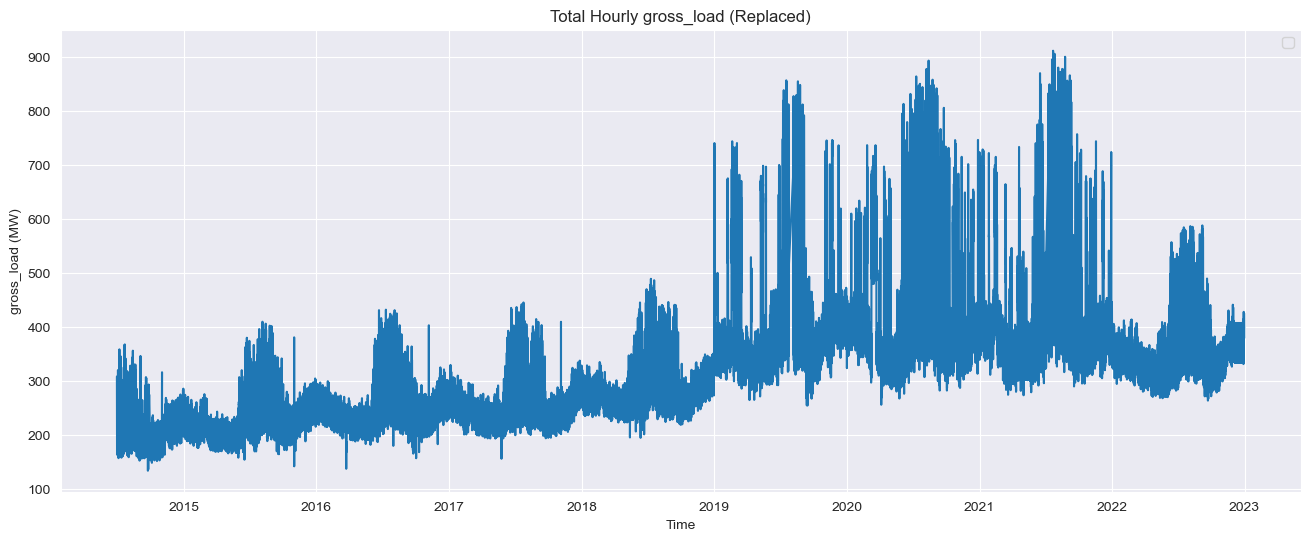

In [11]:
# replace the outlier values as the average of the previous day and the next day
def replace_outliers_with_avg(s):
    lower_bound = s.quantile(0.01)
    upper_bound = s.quantile(0.99)
    outliers = (s < lower_bound) | (s > upper_bound)
    
    for idx in s[outliers].index:
        if idx == 0 or idx == len(s) - 1:
            # directly drop the first and last value
            s.at[idx] = np.nan
            continue
        prev_val = s.iloc[idx - 1]
        next_val = s.iloc[idx + 1]
        s.at[idx] = (prev_val + next_val) / 2
    return s

# reset index 
df.reset_index(drop=True, inplace=True)
# Assuming df is your DataFrame and 'hour_begins' and 'gross_load' are the relevant columns
df['gross_load_replaced'] = replace_outliers_with_avg(df['gross_load'].copy())

# Number of outliers
print(f'Number of outliers: {df[df["gross_load"] != df["gross_load_replaced"]].shape[0]}')

# Plot the replaced 'gross_load_replaced'
plt.figure(figsize=(16, 6))
plt.plot(df['hour_begins'], df['gross_load_replaced'])
plt.xlabel('Time')
plt.ylabel('gross_load (MW)')
plt.title('Total Hourly gross_load (Replaced)')
plt.legend()
plt.show()

In [13]:
# calculate the daily average load
df['date'] = df['hour_begins'].dt.date
daily_gross_load = df.groupby('date')['gross_load_replaced'].mean().reset_index()
daily_high = df.groupby('date')['gross_load_replaced'].max().reset_index()
daily_low = df.groupby('date')['gross_load_replaced'].min().reset_index()
daily_std = df.groupby('date')['gross_load_replaced'].std().reset_index()

daily_gross_load['daily_high'] = daily_high['gross_load_replaced']
daily_gross_load['daily_low'] = daily_low['gross_load_replaced']
daily_gross_load['daily_std'] = daily_std['gross_load_replaced']

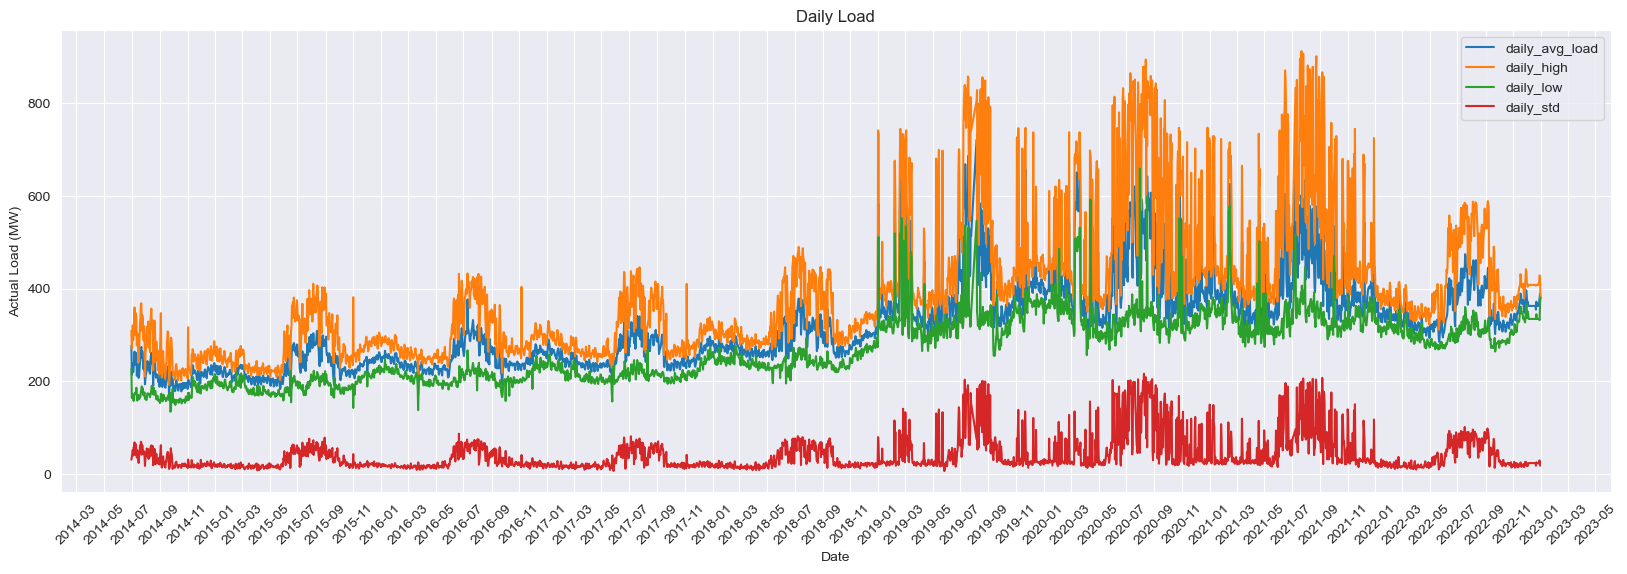

In [15]:
import matplotlib.dates as mdates
# plot the daily average, min, max, std
plt.figure(figsize=(20, 6))
plt.plot(daily_gross_load['date'], daily_gross_load['gross_load_replaced'], label='daily_avg_load')
plt.plot(daily_gross_load['date'], daily_gross_load['daily_high'], label='daily_high')
plt.plot(daily_gross_load['date'], daily_gross_load['daily_low'], label='daily_low')
plt.plot(daily_gross_load['date'], daily_gross_load['daily_std'], label='daily_std')
plt.xlabel('Date')
plt.ylabel('Actual Load (MW)')
plt.title('Daily Load')
plt.legend()

# Set date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # set to show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

In [16]:
# day of the week, month, year, season vairables
daily_gross_load['date'] = pd.to_datetime(daily_gross_load['date'])
daily_gross_load['day_of_week'] = daily_gross_load['date'].dt.dayofweek
daily_gross_load['month'] = daily_gross_load['date'].dt.month
daily_gross_load['year'] = daily_gross_load['date'].dt.year
daily_gross_load['seasons'] = (daily_gross_load['month']%12 + 3)//3
seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
daily_gross_load['seasons'] = daily_gross_load['seasons'].map(seasons)

In [17]:
daily_gross_load['month_sin'] = np.sin((daily_gross_load['month'] - 1) * (2. * np.pi / 12))
daily_gross_load['month_cos'] = np.cos((daily_gross_load['month'] - 1) * (2. * np.pi / 12))
daily_gross_load['dow_sin'] = np.sin(daily_gross_load['day_of_week'] * (2. * np.pi / 7))
daily_gross_load['dow_cos'] = np.cos(daily_gross_load['day_of_week'] * (2. * np.pi / 7))

In [18]:
# holiday - 0/1 binary
us_holidays = holidays.US()
daily_gross_load['holiday'] = daily_gross_load['date'].apply(lambda x: 1 if x in us_holidays else 0)

In [19]:
daily_gross_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3084 entries, 0 to 3083
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 3084 non-null   datetime64[ns]
 1   gross_load_replaced  3084 non-null   float64       
 2   daily_high           3084 non-null   float64       
 3   daily_low            3084 non-null   float64       
 4   daily_std            3081 non-null   float64       
 5   day_of_week          3084 non-null   int32         
 6   month                3084 non-null   int32         
 7   year                 3084 non-null   int32         
 8   seasons              3084 non-null   object        
 9   month_sin            3084 non-null   float64       
 10  month_cos            3084 non-null   float64       
 11  dow_sin              3084 non-null   float64       
 12  dow_cos              3084 non-null   float64       
 13  holiday              3084 non-nul

In [20]:
# print out the numerical and categorical features
numerical_features = daily_gross_load.select_dtypes(include=['float64']).columns.tolist()
categorical_features = daily_gross_load.select_dtypes(include=['datetime64[ns]', 'object', 'bool','int32','int64']).columns.tolist()
target = 'gross_load_replaced'
numerical_features.remove(target)
print(f'Target variable: {target}')
print(f'Numerical features: {numerical_features}')
print(f'Categorical features: {categorical_features}')

# put categorical features first, numerical features last
daily_gross_load = daily_gross_load[categorical_features + numerical_features + [target]]
daily_gross_load

Target variable: gross_load_replaced
Numerical features: ['daily_high', 'daily_low', 'daily_std', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Categorical features: ['date', 'day_of_week', 'month', 'year', 'seasons', 'holiday']


,date,day_of_week,month,year,seasons,holiday,daily_high,daily_low,daily_std,month_sin,month_cos,dow_sin,dow_cos,gross_load_replaced
0,2014-06-30,0,6,2014,Summer,0,308.789,227.963000,30.755850,5.000000e-01,-0.866025,0.000000,1.000000,276.425000
1,2014-07-01,1,7,2014,Summer,0,270.536,164.059250,37.029813,1.224647e-16,-1.000000,0.781831,0.623490,213.675841
2,2014-07-02,2,7,2014,Summer,0,293.088,170.128500,43.785689,1.224647e-16,-1.000000,0.974928,-0.222521,228.660385
3,2014-07-03,3,7,2014,Summer,0,320.664,171.598000,51.701347,1.224647e-16,-1.000000,0.433884,-0.900969,238.796479
4,2014-07-04,4,7,2014,Summer,1,288.666,163.773375,39.977119,1.224647e-16,-1.000000,-0.433884,-0.900969,219.523096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079,2022-12-27,1,12,2022,Winter,0,410.598,334.419000,22.981459,-5.000000e-01,0.866025,0.781831,0.623490,366.958000
3080,2022-12-28,2,12,2022,Winter,0,414.803,334.068000,23.385403,-5.000000e-01,0.866025,0.974928,-0.222521,367.770125
3081,2022-12-29,3,12,2022,Winter,0,428.508,331.832000,29.358389,-5.000000e-01,0.866025,0.433884,-0.900969,380.010542
3082,2022-12-30,4,12,2022,Winter,0,426.007,362.638000,18.146081,-5.000000e-01,0.866025,-0.433884,-0.900969,388.598958


In [472]:
daily_gross_load.drop(columns=['daily_high', 'daily_low', 'daily_std'], inplace=True)
daily_gross_load

,date,day_of_week,month,year,seasons,holiday,month_sin,month_cos,dow_sin,dow_cos,gross_load_replaced
0,2019-01-01,1,1,2019,Winter,1,0.000000e+00,1.0,0.781831,0.623490,89.325217
1,2019-01-02,2,1,2019,Winter,0,0.000000e+00,1.0,0.974928,-0.222521,97.675229
2,2019-01-03,3,1,2019,Winter,0,0.000000e+00,1.0,0.433884,-0.900969,95.822708
3,2019-01-04,4,1,2019,Winter,0,0.000000e+00,1.0,-0.433884,-0.900969,91.134542
4,2019-01-05,5,1,2019,Winter,0,0.000000e+00,1.0,-0.974928,-0.222521,85.262958
...,...,...,...,...,...,...,...,...,...,...,...
1260,2024-07-27,5,7,2024,Summer,0,1.224647e-16,-1.0,-0.974928,-0.222521,67.696830
1261,2024-07-28,6,7,2024,Summer,0,1.224647e-16,-1.0,-0.781831,0.623490,63.202256
1262,2024-07-29,0,7,2024,Summer,0,1.224647e-16,-1.0,0.000000,1.000000,67.268965
1263,2024-07-30,1,7,2024,Summer,0,1.224647e-16,-1.0,0.781831,0.623490,71.471539


In [473]:
daily_gross_load.columns

Index(['date', 'day_of_week', 'month', 'year', 'seasons', 'holiday',
       'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'gross_load_replaced'],
      dtype='object')

##  scaling and encoding

In [21]:
# encoding the categorical features - season only at the second column of values
daily_gross_load = pd.get_dummies(daily_gross_load, columns=['seasons'], drop_first=True) # at the last 3 columns
# Convert boolean columns to integers
for col in daily_gross_load.columns:
    if daily_gross_load[col].dtype == 'bool':
        daily_gross_load[col] = daily_gross_load[col].astype(int)
# place the target variable at the last column
daily_gross_load = daily_gross_load[[c for c in daily_gross_load if c not in ['gross_load_replaced']] + ['gross_load_replaced']]

In [22]:
daily_gross_load

,date,day_of_week,month,year,holiday,daily_high,daily_low,daily_std,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,gross_load_replaced
0,2014-06-30,0,6,2014,0,308.789,227.963000,30.755850,5.000000e-01,-0.866025,0.000000,1.000000,0,1,0,276.425000
1,2014-07-01,1,7,2014,0,270.536,164.059250,37.029813,1.224647e-16,-1.000000,0.781831,0.623490,0,1,0,213.675841
2,2014-07-02,2,7,2014,0,293.088,170.128500,43.785689,1.224647e-16,-1.000000,0.974928,-0.222521,0,1,0,228.660385
3,2014-07-03,3,7,2014,0,320.664,171.598000,51.701347,1.224647e-16,-1.000000,0.433884,-0.900969,0,1,0,238.796479
4,2014-07-04,4,7,2014,1,288.666,163.773375,39.977119,1.224647e-16,-1.000000,-0.433884,-0.900969,0,1,0,219.523096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079,2022-12-27,1,12,2022,0,410.598,334.419000,22.981459,-5.000000e-01,0.866025,0.781831,0.623490,0,0,1,366.958000
3080,2022-12-28,2,12,2022,0,414.803,334.068000,23.385403,-5.000000e-01,0.866025,0.974928,-0.222521,0,0,1,367.770125
3081,2022-12-29,3,12,2022,0,428.508,331.832000,29.358389,-5.000000e-01,0.866025,0.433884,-0.900969,0,0,1,380.010542
3082,2022-12-30,4,12,2022,0,426.007,362.638000,18.146081,-5.000000e-01,0.866025,-0.433884,-0.900969,0,0,1,388.598958


In [23]:
# scaling the columns except for the 1 column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
daily_gross_load.iloc[:, 1:] = scaler.fit_transform(daily_gross_load.iloc[:, 1:])
daily_gross_load

,date,day_of_week,month,year,holiday,daily_high,daily_low,daily_std,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,gross_load_replaced
0,2014-06-30,0.000000,0.454545,0.0,0,0.161656,0.178549,0.116244,0.75,0.066987,0.500000,1.000000e+00,0,1,0,0.186851
1,2014-07-01,0.166667,0.545455,0.0,0,0.108501,0.056691,0.146126,0.50,0.000000,0.900969,8.019377e-01,0,1,0,0.077590
2,2014-07-02,0.333333,0.545455,0.0,0,0.139839,0.068265,0.178303,0.50,0.000000,1.000000,3.568959e-01,0,1,0,0.103681
3,2014-07-03,0.500000,0.545455,0.0,0,0.178157,0.071067,0.216004,0.50,0.000000,0.722521,5.551115e-17,0,1,0,0.121331
4,2014-07-04,0.666667,0.545455,0.0,1,0.133694,0.056146,0.160164,0.50,0.000000,0.277479,0.000000e+00,0,1,0,0.087771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079,2022-12-27,0.166667,1.000000,1.0,0,0.303126,0.381550,0.079216,0.25,0.933013,0.900969,8.019377e-01,0,0,1,0.344491
3080,2022-12-28,0.333333,1.000000,1.0,0,0.308969,0.380881,0.081140,0.25,0.933013,1.000000,3.568959e-01,0,0,1,0.345905
3081,2022-12-29,0.500000,1.000000,1.0,0,0.328013,0.376617,0.109588,0.25,0.933013,0.722521,5.551115e-17,0,0,1,0.367218
3082,2022-12-30,0.666667,1.000000,1.0,0,0.324538,0.435361,0.056186,0.25,0.933013,0.277479,0.000000e+00,0,0,1,0.382173


In [24]:
# save the values of column gross_load_replaced, drop it and the attach at the last column 
gross_load_replaced = daily_gross_load['gross_load_replaced']
daily_gross_load.drop(columns='gross_load_replaced', inplace=True)
daily_gross_load['gross_load_replaced'] = gross_load_replaced
daily_gross_load

,date,day_of_week,month,year,holiday,daily_high,daily_low,daily_std,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,gross_load_replaced
0,2014-06-30,0.000000,0.454545,0.0,0,0.161656,0.178549,0.116244,0.75,0.066987,0.500000,1.000000e+00,0,1,0,0.186851
1,2014-07-01,0.166667,0.545455,0.0,0,0.108501,0.056691,0.146126,0.50,0.000000,0.900969,8.019377e-01,0,1,0,0.077590
2,2014-07-02,0.333333,0.545455,0.0,0,0.139839,0.068265,0.178303,0.50,0.000000,1.000000,3.568959e-01,0,1,0,0.103681
3,2014-07-03,0.500000,0.545455,0.0,0,0.178157,0.071067,0.216004,0.50,0.000000,0.722521,5.551115e-17,0,1,0,0.121331
4,2014-07-04,0.666667,0.545455,0.0,1,0.133694,0.056146,0.160164,0.50,0.000000,0.277479,0.000000e+00,0,1,0,0.087771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079,2022-12-27,0.166667,1.000000,1.0,0,0.303126,0.381550,0.079216,0.25,0.933013,0.900969,8.019377e-01,0,0,1,0.344491
3080,2022-12-28,0.333333,1.000000,1.0,0,0.308969,0.380881,0.081140,0.25,0.933013,1.000000,3.568959e-01,0,0,1,0.345905
3081,2022-12-29,0.500000,1.000000,1.0,0,0.328013,0.376617,0.109588,0.25,0.933013,0.722521,5.551115e-17,0,0,1,0.367218
3082,2022-12-30,0.666667,1.000000,1.0,0,0.324538,0.435361,0.056186,0.25,0.933013,0.277479,0.000000e+00,0,0,1,0.382173


In [25]:
daily_gross_load = daily_gross_load.dropna()
daily_gross_load.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3081 entries, 0 to 3082
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 3081 non-null   datetime64[ns]
 1   day_of_week          3081 non-null   float64       
 2   month                3081 non-null   float64       
 3   year                 3081 non-null   float64       
 4   holiday              3081 non-null   int64         
 5   daily_high           3081 non-null   float64       
 6   daily_low            3081 non-null   float64       
 7   daily_std            3081 non-null   float64       
 8   month_sin            3081 non-null   float64       
 9   month_cos            3081 non-null   float64       
 10  dow_sin              3081 non-null   float64       
 11  dow_cos              3081 non-null   float64       
 12  seasons_Spring       3081 non-null   int32         
 13  seasons_Summer       3081 non-null   i

# dividing the data into training and testing

In [26]:
years_of_data = len(daily_gross_load) / 365
print(f'Total years of data: {years_of_data}')

Total years of data: 8.441095890410958


In [27]:
# out of sample data: final 1 years
ofs_number = 365
daily_gross_load_ofs = daily_gross_load.iloc[-ofs_number:, :]
daily_gross_load = daily_gross_load.iloc[:-ofs_number, :]
print(f'start date of out of sample data: {daily_gross_load_ofs["date"].min()}')
print(f'end date of out of sample data: {daily_gross_load_ofs["date"].max()}')

start date of out of sample data: 2021-12-30 00:00:00
end date of out of sample data: 2022-12-30 00:00:00


In [28]:
# total number of days for training and testing
print(f'Total number of days for training: {daily_gross_load.shape[0]}')

Total number of days for training: 2716


In [29]:
daily_gross_load = daily_gross_load.sort_values(by='date')
values = daily_gross_load.drop(columns='date').values
dates = daily_gross_load['date']

# out of sample data: total length multiplies 0.3
train_days = int(values.shape[0] * 0.8)
# in sample data: the rest of the data
train = values[:train_days, :]
train_timestamps = dates[:train_days]
# print(f'start date of in sample data: {train["date"].min()}')
# print(f'end date of in sample data: {train["date"].max()}')
# print(f'length of in sample data: {train.
# shape[0]}\n')

print(f'min: {train_timestamps.min()}')
print(f'max: {train_timestamps.max()}')
print(f'length of in sample data: {train.shape[0]}\n')

test = values[train_days:, : ]
test_timestamps = dates[train_days:]
# print(f'start date of out of sample data: {test["date"].min()}')
# print(f'end date of out of sample data: {test["date"].max()}')
# print(f'length of out of sample data: {test.shape[0]}\n')

print(f'min: {test_timestamps.min()}')
print(f'max: {test_timestamps.max()}')
print(f'length of out of sample data: {test.shape[0]}')

min: 2014-06-30 00:00:00
max: 2020-06-28 00:00:00
length of in sample data: 2172

min: 2020-06-29 00:00:00
max: 2021-12-29 00:00:00
length of out of sample data: 544


In [30]:
# dividing the data into x and y
# x: All columns except the last,  y: The last column
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2172, 1, 14) (2172,) (544, 1, 14) (544,)


In [40]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# design network

# Define the model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['mae', 'mse', 'mape'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-3)

# Fit the network
history = model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False,callbacks=[early_stopping, reduce_lr])

# Calculate MAPE manually, handling zero values
def safe_mape(y_true, y_pred, epsilon=1e-10):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100

train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)
# calculate train validate rmse, mae, mape
train_rmse = np.sqrt(mean_squared_error(train_y, train_predictions))
train_mae = mean_absolute_error(train_y, train_predictions)
train_mape = safe_mape(train_y, train_predictions)

test_rmse = np.sqrt(mean_squared_error(test_y, test_predictions))
test_mae = mean_absolute_error(test_y, test_predictions)
test_mape = safe_mape(test_y, test_predictions)

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Train MAPE: {train_mape:.2f}%")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")

Epoch 1/100
22/22 - 1s - 64ms/step - loss: 0.1152 - mae: 0.1152 - mape: 11600.2900 - mse: 0.0235 - val_loss: 0.1582 - val_mae: 0.1582 - val_mape: 30.7229 - val_mse: 0.0434 - learning_rate: 0.0010
Epoch 2/100
22/22 - 0s - 2ms/step - loss: 0.1287 - mae: 0.1287 - mape: 110783.7188 - mse: 0.0257 - val_loss: 0.1670 - val_mae: 0.1670 - val_mape: 33.4415 - val_mse: 0.0425 - learning_rate: 0.0010
Epoch 3/100
22/22 - 0s - 2ms/step - loss: 0.1005 - mae: 0.1005 - mape: 67161.6719 - mse: 0.0178 - val_loss: 0.1633 - val_mae: 0.1633 - val_mape: 33.7688 - val_mse: 0.0367 - learning_rate: 0.0010
Epoch 4/100
22/22 - 0s - 2ms/step - loss: 0.0795 - mae: 0.0795 - mape: 46100.3281 - mse: 0.0119 - val_loss: 0.1217 - val_mae: 0.1217 - val_mape: 24.8795 - val_mse: 0.0219 - learning_rate: 0.0010
Epoch 5/100
22/22 - 0s - 2ms/step - loss: 0.0732 - mae: 0.0732 - mape: 42278.2969 - mse: 0.0098 - val_loss: 0.0968 - val_mae: 0.0968 - val_mape: 19.7921 - val_mse: 0.0147 - learning_rate: 0.0010
Epoch 6/100
22/22 - 0s 

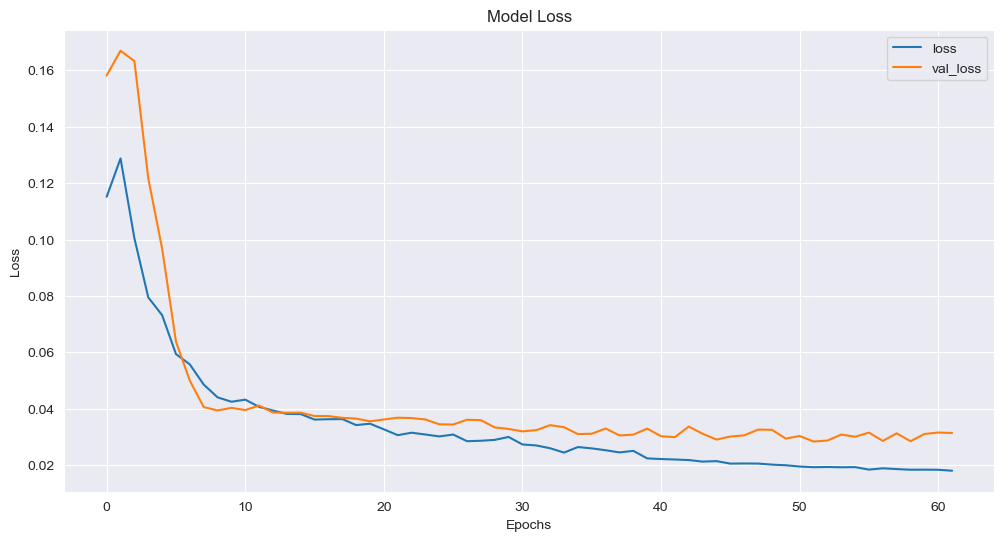

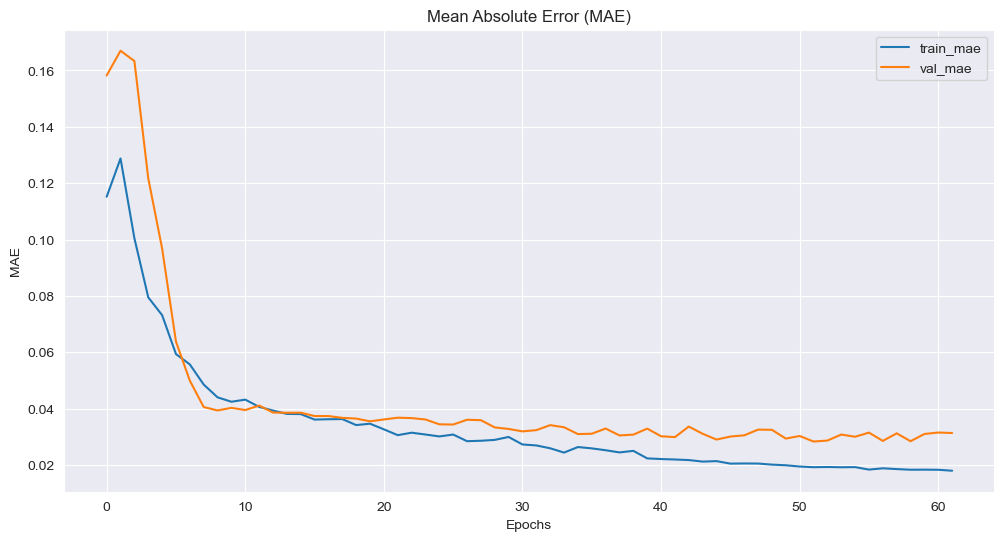

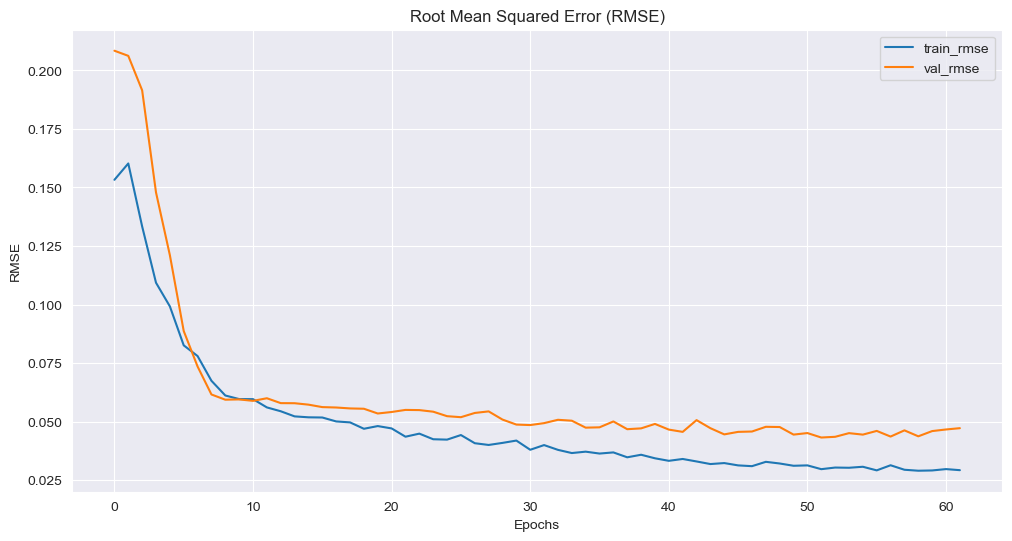

In [41]:
# Plot history for loss, MAE, and RMSE as before
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.show()

train_rmse = np.sqrt(history.history['mse'])
val_rmse = np.sqrt(history.history['val_mse'])
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='train_rmse')
plt.plot(val_rmse, label='val_rmse')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Root Mean Squared Error (RMSE)')
plt.show()

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# Make predictions using the existing model
yhat = model.predict(test_X)

# Reshape test_X for inverse scaling
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((test_X_reshaped,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]

# Invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X_reshaped, test_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]

# Calculate RMSE, MAE, MAPE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
RMSE: 24.821
MAE: 16.282
MAPE: 3.606


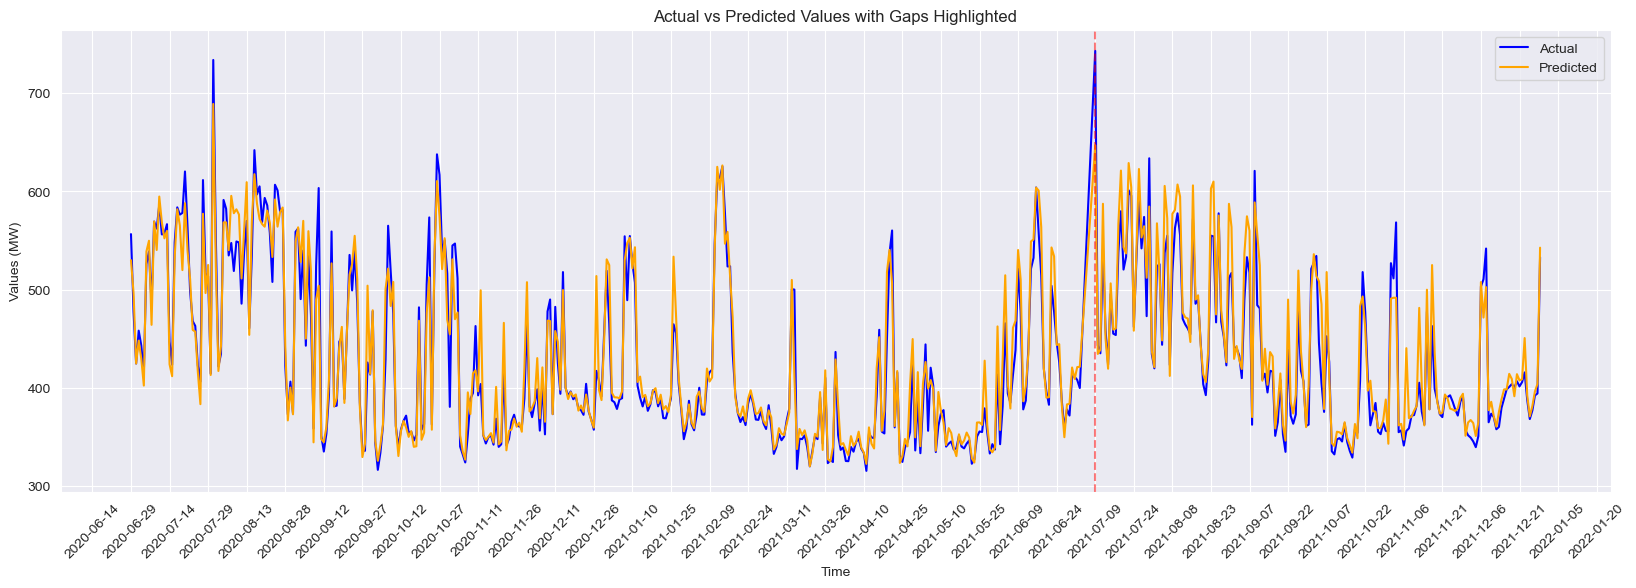

Gaps in data:
Gap Start: 2021-07-03
Gap ends at: 2021-07-09
Time Difference: 6.0 days



In [43]:
# Extract the test data with timestamps
test_df = daily_gross_load.iloc[train_days:, :].copy()
test_df['date'] = daily_gross_load.iloc[train_days:]['date']

# Identify gaps in the data
actual_vs_predicted = pd.DataFrame({
    'date': test_timestamps,
    'actual': inv_y,
    'predicted': inv_yhat
})

# Check for gaps in the timestamps (in days)
actual_vs_predicted['date_diff'] = actual_vs_predicted['date'].diff().dt.days
gaps = actual_vs_predicted[actual_vs_predicted['date_diff'] > 1]

# Plot actual vs predicted values with gaps highlighted
plt.figure(figsize=(20, 6))
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['actual'], label='Actual', color='blue')
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['predicted'], label='Predicted', color='orange')
for gap_start in gaps['date']:
    plt.axvline(x=gap_start, color='red', linestyle='--', alpha=0.5)
plt.title('Actual vs Predicted Values with Gaps Highlighted')
plt.xlabel('Time')
plt.ylabel('Values (MW)')
plt.legend()
plt.grid(True)

# Set date format on x-axis every 15 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.show()

# Print the gaps and their nearest significant time differences
print("Gaps in data:")
for index, row in gaps.iterrows():
    previous_timestamp = row['date'] - pd.Timedelta(days=row['date_diff'])
    next_timestamp = row['date'] + pd.Timedelta(days=row['date_diff'])

    previous_row = actual_vs_predicted[actual_vs_predicted['date'] == previous_timestamp]
    next_row = actual_vs_predicted[actual_vs_predicted['date'] == next_timestamp]

    gap_start = previous_row['date'].values[0] if not previous_row.empty else 'N/A'
    gap_end = row['date']

    print(f"Gap Start: {pd.to_datetime(gap_start).strftime('%Y-%m-%d') if gap_start != 'N/A' else 'N/A'}")
    print(f"Gap ends at: {gap_end.strftime('%Y-%m-%d')}")
    print(f"Time Difference: {row['date_diff']} days\n")

# out of sample data

In [44]:
daily_gross_load_ofs = daily_gross_load_ofs.sort_values(by='date')
ofs_values = daily_gross_load_ofs.drop(columns='date').values
ofs_dates = daily_gross_load_ofs['date']

# Split into input and output
ofs_X, ofs_y = ofs_values[:, :-1], ofs_values[:, -1]
# Reshape input to be 3D [number of samples, timesteps, number of features]
ofs_X = ofs_X.reshape((ofs_X.shape[0], 1, ofs_X.shape[1]))

In [45]:
# dividing the data into x and y
# x: All columns except the last,  y: The last column
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2172, 1, 14) (2172,) (544, 1, 14) (544,)


In [46]:
# concatenate is not defined
from numpy import concatenate
# Make predictions
ofs_predictions = model.predict(ofs_X)

# Reshape OFS data to original 2D shape for inverse transformation
ofs_X_reshaped = ofs_X.reshape((ofs_X.shape[0], ofs_X.shape[2]))

# Invert scaling for forecast
inv_ofs_predictions = concatenate((ofs_X_reshaped, ofs_predictions), axis=1)
inv_ofs_predictions = scaler.inverse_transform(inv_ofs_predictions)
inv_ofs_predictions = inv_ofs_predictions[:, -1]  # First column

# Invert scaling for actual
ofs_y = ofs_y.reshape((len(ofs_y), 1))
inv_ofs_y = concatenate((ofs_X_reshaped, ofs_y), axis=1)
inv_ofs_y = scaler.inverse_transform(inv_ofs_y)
inv_ofs_y = inv_ofs_y[:, -1]  # First column

# Calculate RMSE, MAE, MAPE
ofs_rmse = sqrt(mean_squared_error(inv_ofs_y, inv_ofs_predictions))
ofs_mae = mean_absolute_error(inv_ofs_y, inv_ofs_predictions)
ofs_mape = np.mean(np.abs((inv_ofs_y - inv_ofs_predictions) / inv_ofs_y)) * 100

print('OFS RMSE: %.3f' % ofs_rmse)
print('OFS MAE: %.3f' % ofs_mae)
print('OFS MAPE: %.3f' % ofs_mape)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
OFS RMSE: 10.000
OFS MAE: 8.622
OFS MAPE: 2.475


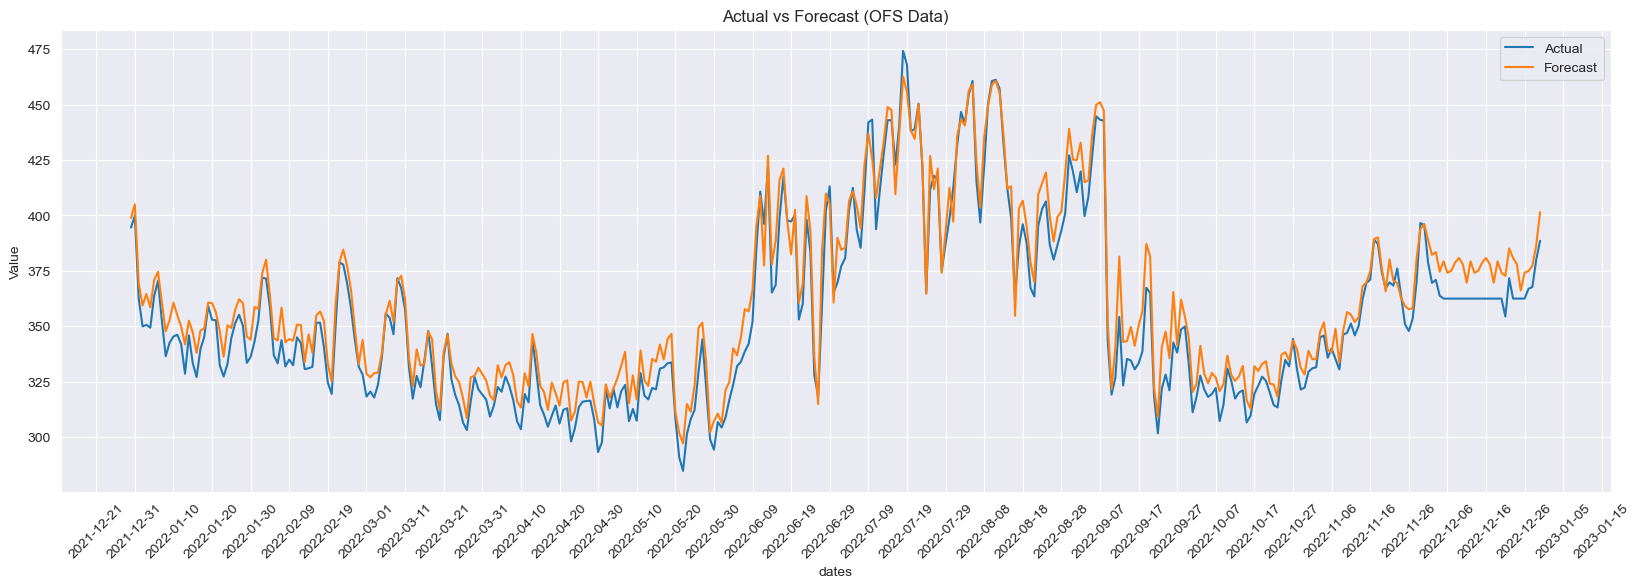

In [47]:
# Plot prediction vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(ofs_dates, inv_ofs_y, label='Actual')
plt.plot(ofs_dates, inv_ofs_predictions, label='Forecast')
plt.title('Actual vs Forecast (OFS Data)')
plt.ylabel('Value')
plt.xlabel('dates')
plt.legend()
# Set date format on x-axis every 15 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.show()